In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import plotly.graph_objects as go
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import jax
from copy import deepcopy


jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

In [3]:
from synbio_morpher.scripts.parameter_based_simulation.run_parameter_based_simulation import make_interaction_matrices
from synbio_morpher.utils.common.testing.minimal_sim import mini_sim
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range

# Load analytic

In [4]:
sdir = '../data/parameter_based_simulation/2023_09_07_155734'
analytic_name = 'precision'
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']
param_range = create_parameter_range(config['parameter_based_simulation'])


In [5]:
a = {}
for f in os.listdir(sdir):
    if f.endswith('npy'):
        a[f.split('.')[0]] = np.load(os.path.join(sdir, f))

# Find top circuits

In [6]:
def find_top_n_peaks(arrs: list, n: int):
    """ Find the top n peaks across the multi-dimensional arrays in arrs """
    top_peaks = []
    for ni in range(n):

        objective = arrs[0] / arrs[0].max()
        for arr in arrs[1:]:
            objective += arr / arr.max()
        top_peak = np.argmax(objective)
        top_peak_idx = np.unravel_index(top_peak, arr.shape)

        for i in range(len(arrs)):
            arrs[i][top_peak_idx] = 0

        # next_top_peaks = find_top_n_peaks(arrs, n=n-1)
        # if (np.sum(top_peak_idx) >= np.sum(next_top_peaks[-1]) + 1) & (
        #     np.sum(top_peak_idx) <= np.sum(next_top_peaks[-1]) - 1
        # ):
        top_peaks.append(top_peak_idx)
        # top_peaks = top_peaks + next_top_peaks

    return top_peaks


def filter_top_peaks(top_indices, radius: int):
    chosen = [0]
    for i, t in enumerate(top_indices[1:]):
        # if (np.sum(np.abs(np.array(t) - np.array(top_indices[i]))) > radius):
        # if np.sum(np.power(np.array(t) - np.array(top_indices[i]), 0.5)) > radius:
        if np.sum((np.array(t) - np.array(top_indices[i])) == 0) == 0:
            chosen.append(i+1)
    top_indices = [top_indices[i] for i in chosen]
    return top_indices

## Setting for best circuits

In [7]:
n_top = 10000
i_spec = 1
radius = 2

pp = np.where(a['precision_wrt_species-6'] > 1e1,
              1e1, a['precision_wrt_species-6'])
# Overshoot / signal diff
oo = np.where((a['max_amount'][0] - a['initial_steady_states'][0]) == 0,
              0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))
oo = np.where(oo < 1e-4, 0, oo)
# oo = np.where(a['overshoot'] < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
# oo = np.where(oo < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
arrs = [a['sensitivity_wrt_species-6'][i_spec], pp[i_spec], oo[i_spec]]
top_indices = find_top_n_peaks(deepcopy(arrs), n=n_top)
n_ind = len(top_indices)
n_prev = 0
while n_ind != n_prev:
    n_prev = len(top_indices)
    top_indices = filter_top_peaks(top_indices, radius=radius)
    n_ind = len(top_indices)

print(len(top_indices))
top_indices

/tmp/ipykernel_60904/3073157157.py:9: RuntimeWarning: invalid value encountered in divide
  0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))


902


[(8, 2, 0, 1, 4, 5),
 (4, 5, 4, 7, 5, 7),
 (7, 2, 0, 2, 4, 5),
 (3, 5, 3, 8, 0, 1),
 (4, 2, 0, 2, 4, 7),
 (3, 5, 3, 7, 0, 1),
 (0, 2, 1, 2, 4, 5),
 (3, 5, 3, 7, 2, 1),
 (8, 2, 0, 1, 4, 8),
 (3, 5, 3, 7, 1, 2),
 (7, 2, 0, 1, 4, 8),
 (3, 5, 3, 7, 0, 2),
 (1, 2, 0, 2, 4, 5),
 (4, 5, 4, 6, 5, 6),
 (1, 2, 1, 2, 4, 5),
 (3, 5, 3, 6, 2, 0),
 (6, 2, 0, 0, 4, 8),
 (3, 5, 3, 6, 1, 2),
 (8, 2, 2, 1, 4, 5),
 (3, 5, 0, 7, 0, 3),
 (1, 2, 1, 1, 4, 5),
 (4, 5, 3, 8, 0, 3),
 (6, 2, 1, 0, 4, 8),
 (4, 5, 3, 7, 0, 3),
 (6, 2, 1, 1, 4, 8),
 (4, 5, 3, 6, 0, 3),
 (7, 2, 2, 2, 4, 7),
 (4, 5, 3, 6, 1, 3),
 (7, 2, 2, 2, 4, 8),
 (4, 5, 4, 8, 5, 5),
 (5, 2, 0, 0, 4, 7),
 (4, 5, 3, 6, 2, 3),
 (7, 2, 2, 1, 4, 6),
 (4, 5, 3, 6, 0, 7),
 (8, 2, 2, 1, 4, 6),
 (3, 5, 0, 6, 2, 3),
 (6, 2, 2, 1, 4, 6),
 (4, 5, 3, 8, 3, 3),
 (3, 0, 2, 4, 4, 8),
 (4, 5, 3, 6, 1, 6),
 (8, 2, 2, 1, 4, 7),
 (4, 5, 4, 6, 3, 3),
 (3, 1, 2, 4, 4, 8),
 (4, 5, 3, 6, 3, 3),
 (3, 1, 2, 4, 4, 6),
 (5, 5, 4, 8, 5, 7),
 (3, 2, 2, 4, 4, 5),
 (4, 5, 3, 8,

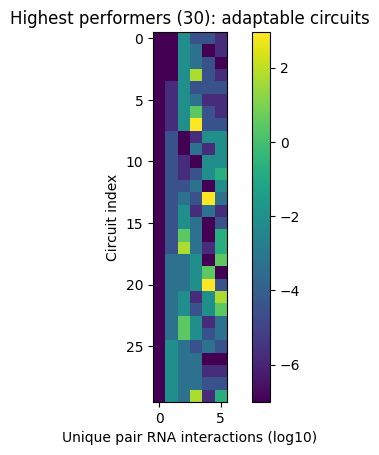

In [19]:
plt.imshow(np.log10(param_range[sorted(top_indices)[:30]]))
plt.colorbar()
plt.ylabel('Circuit index')
plt.xlabel('Unique pair RNA interactions (log10)')
plt.title('Highest performers (30): adaptable circuits')
plt.savefig('motifs.svg')

Text(0, 0.5, 'Sensitivity')

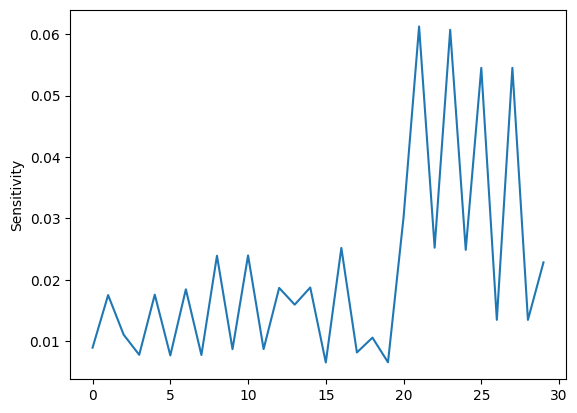

In [28]:
z = np.zeros(30)
for i, t in enumerate(top_indices[:30]):
    z[i] = a['sensitivity_wrt_species-6'][i_spec][tuple(t)]

plt.plot(z)
plt.ylabel('Sensitivity')

In [8]:
print('sensivity \t overshoot \t precision')
for t in top_indices:
    print(a['sensitivity_wrt_species-6'][1][tuple(t)], '\t', a['overshoot'][1][tuple(t)], '\t', a['precision_wrt_species-6'][1][t])

sensivity 	 overshoot 	 precision
0.008954429 	 0.012170076 	 1289.2474
0.0175122 	 2.042862 	 597.73047
0.0110609615 	 0.005744934 	 128.53938
0.007783912 	 0.71829224 	 1064.5588
0.017586473 	 0.003259778 	 62.956425
0.0076850164 	 0.7130203 	 1132.6738
0.018451588 	 0.0021249056 	 57.552452
0.0077554574 	 0.7033844 	 932.97455
0.023923287 	 0.0031286478 	 44.99614
0.008710526 	 0.6797943 	 546.6902
0.023970036 	 0.0031108856 	 44.883648
0.008719887 	 0.679245 	 542.9879
0.01868314 	 0.0021187067 	 56.784084
0.015956637 	 1.6802216 	 517.8737
0.018753305 	 0.002105236 	 56.53741
0.006538026 	 0.63482666 	 4518.9126
0.025192028 	 0.0025613308 	 42.048714
0.008168956 	 0.56658936 	 425.3572
0.010583097 	 0.010476589 	 288.20728
0.0065686195 	 0.45755768 	 2334.9377
0.03015532 	 0.0016866922 	 34.25698
0.061260488 	 1.6935425 	 31.53236
0.025230112 	 0.0025100708 	 41.93276
0.060717583 	 1.6912041 	 32.078564
0.02487549 	 0.0025070906 	 42.54562
0.05451704 	 1.5897102 	 38.70009
0.01348

In [9]:
config['simulation']


{'dt0': 0.01,
 't0': 0,
 't1': 100,
 'tmax': 120000,
 'solver': 'diffrax',
 'use_batch_mutations': True,
 'batch_size': 10000,
 'max_circuits': 20000,
 'device': 'gpu',
 'threshold_steady_states': 0.05,
 'use_rate_scaling': True}

## Run mini sim


In [10]:
# jax.config.update('jax_platform_name', 'gpu')

In [11]:
saves = {}
for i, ti in enumerate(top_indices[:50]):
    r, analytics, y, t = mini_sim(*param_range[np.array(ti)])
    saves[i] = {
        'analytics': analytics,
        'y': y,
        't': t
    }
    if np.mod(i, 50) == 0:
        print(i, '/', len(top_indices[:50]))

xla_bridge.py:backends():450: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA INFO
xla_bridge.py:backends():450: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():450: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


0 / 50


0 	 0.0013343918 	 5.9604645e-08 	 749.4051
1 	 0.010214551 	 36.008728 	 4293.6406
2 	 0.0013500787 	 0.0 	 740.6976
3 	 0.007166677 	 37.08944 	 1224.4685
4 	 0.005150805 	 0.4148643 	 231.79071
5 	 0.007111146 	 36.674843 	 1234.5117
6 	 2.5846724e-05 	 2.457293 	 1437371.0
7 	 0.007107952 	 36.717445 	 1243.8927
8 	 0.0011729443 	 1.4901161e-07 	 852.55536
9 	 0.0071111317 	 36.442375 	 1188.6718
10 	 0.0011953806 	 2.9802322e-08 	 836.55365
11 	 0.0071112397 	 36.440178 	 1188.2979
12 	 2.6498174e-05 	 2.45681 	 1389420.1
13 	 0.0089398315 	 29.280663 	 3605.3877
14 	 2.7805692e-05 	 2.4569173 	 1336599.2
15 	 0.006252318 	 30.529457 	 1413.251
16 	 0.001550398 	 1.1920929e-07 	 644.99567
17 	 0.0062560416 	 30.298431 	 1346.5851
18 	 0.0015117935 	 0.0 	 661.466
19 	 0.0067509743 	 35.075844 	 1001.518
20 	 2.7824011e-05 	 2.4491024 	 2293289.0
21 	 0.017454311 	 18.660522 	 123.33048
22 	 0.0015608385 	 5.9604645e-08 	 640.6813
23 	 0.01734076 	 18.451286 	 123.89417
24 	 0.0015

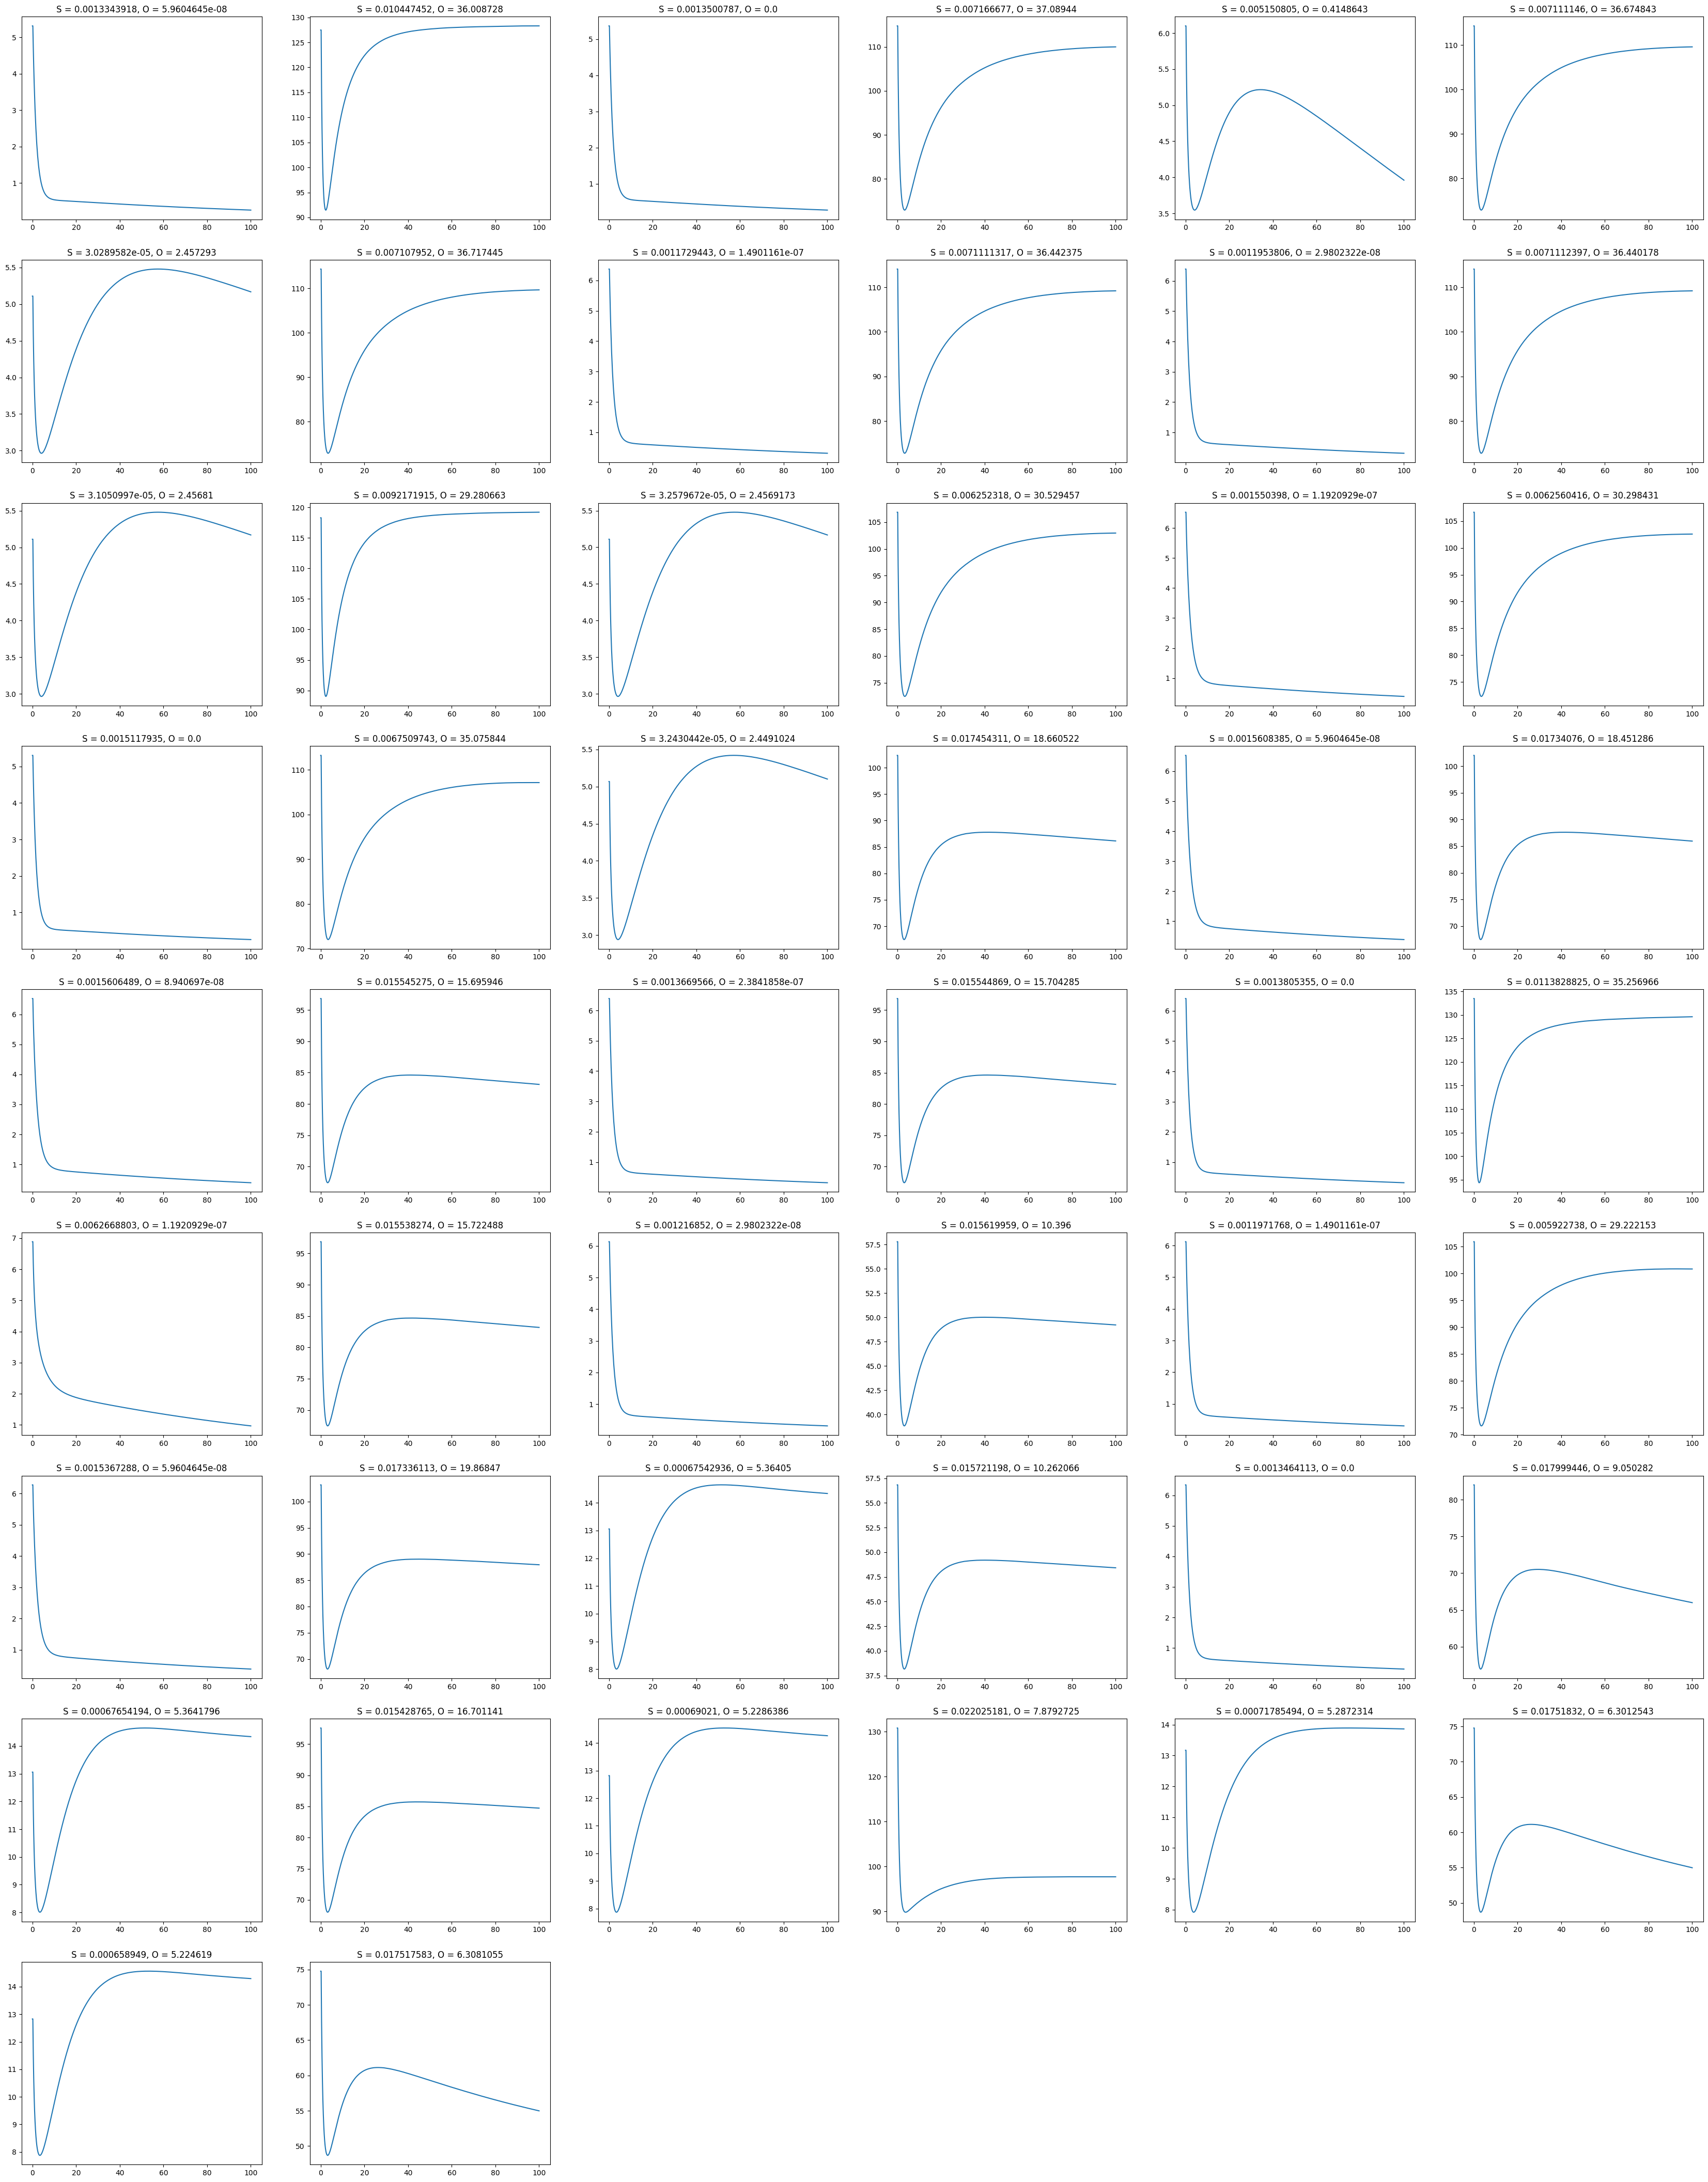

In [12]:
n_rows = np.ceil(len(saves) / 6).astype(int)
n_cols = np.ceil(len(saves) / n_rows).astype(int)
plt.figure(figsize=(7*n_cols, 6*n_rows))
for i, run in saves.items():
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.plot(run['t'], run['y'][:, 7])
    plt.title('S = ' + str(run['analytics']['sensitivity_wrt_species-6'][7]) +
              ', O = ' + str(run['analytics']['overshoot'][7]))

    sensitivity = np.absolute(np.divide(
        np.divide(
            run['analytics']['min_amount'][7] -
            run['analytics']['initial_steady_states'][7],
            run['analytics']['initial_steady_states'][7]),
        np.divide(
            run['analytics']['max_amount'][6] -
            run['analytics']['initial_steady_states'][6],
            run['analytics']['initial_steady_states'][6])
    ))
    print(i, '\t', sensitivity, '\t', run['analytics']['overshoot'][7], '\t', run['analytics']['precision_wrt_species-6'][7])

idk

In [13]:

unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
species = ['RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2', 'RNA_0', 'RNA_1', 'RNA_2']
inds = [i for i, s in enumerate(species) if s in unbound_species]

analytics['sensitivity_wrt_species-6'][:]
analytics['precision_wrt_species-6']


Array([  6.6313767,  44.258812 , 134.81224  ,  43.380463 , 162.70973  ,
        33.296967 ,  20.002325 ,  75.27573  ,  38.404823 ], dtype=float32)

In [14]:
num_species = 3
interaction_matrices, all_interaction_strength_choices = make_interaction_matrices(
    num_species=num_species, interaction_strengths=param_range,
    num_unique_interactions=6, starting_iteration=0, end_iteration=10)

for i, interaction_strength_choices in enumerate(all_interaction_strength_choices):
    idxs = [slice(0, num_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]
    r, analytics, y, t = mini_sim(*interaction_matrices[i][np.triu_indices(num_species)])

    print(f'\nInteraction {i}:')
    print('prev', a['sensitivity_wrt_species-6'][tuple(idxs)])
    print('now', analytics['sensitivity_wrt_species-6'])
    
n_species = 3
r, analytics, y, t = mini_sim(*interaction_matrices[0][np.triu_indices(n_species)])



Interaction 0:
prev [[1.        ]
 [0.11228087]
 [0.11228101]]
now [1.6378406e-02 1.1446339e-04 1.1446339e-04 5.1957983e-07 5.1957983e-07
 5.1957983e-07 1.0000000e+00 3.7805100e-03 3.7805100e-03]

Interaction 1:
prev [[1.        ]
 [0.12741497]
 [0.12741497]]
now [1.64462402e-02 1.14906994e-04 1.14906987e-04 5.21071684e-07
 5.21071854e-07 5.21072025e-07 1.00000000e+00 3.79665568e-03
 3.79665568e-03]

Interaction 2:
prev [[1.        ]
 [0.24300109]
 [0.243001  ]]
now [1.7623227e-02 1.2270245e-04 1.2270245e-04 5.5091891e-07 5.5091897e-07
 5.5091891e-07 1.0000000e+00 4.0782723e-03 4.0782723e-03]

Interaction 3:
prev [[1.        ]
 [0.4336379 ]
 [0.43363798]]
now [3.5959370e-02 2.2936380e-04 2.2936385e-04 9.0953574e-07 9.0953574e-07
 9.0953586e-07 1.0000000e+00 8.5002212e-03 8.5002203e-03]

Interaction 4:
prev [[1.        ]
 [0.12697692]
 [0.12697692]]
now [1.8440747e-01 3.6677180e-04 3.6677191e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 3.9826013e-02 3.9826013e-02]

Inte

In [15]:
for interaction_strength_choices in all_interaction_strength_choices[:1]:
    idxs = [slice(0, n_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]